In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

from cell_inference.config import paths, params
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere, unitsphere2hphi, trivarnorm2unitsphere
from cell_inference.utils.data_manager import NpzFilesCollector

%matplotlib inline

TRIAL_NAME = 'Reduced_Order_stochastic_spkwid_trunkLR4_LactvCa_Loc3_h1_sumstats'

## Load simulation data

In [2]:
DATA_PATH = paths.SIMULATED_DATA_PATH
TRIAL_PATH = os.path.join(DATA_PATH, TRIAL_NAME)

CONFIG_PATH = os.path.join(TRIAL_PATH, 'config.json')  # trial configuration
STATS_PATH = os.path.join(TRIAL_PATH, 'summ_stats.npz')  # summary statistics

try:
    STATS = np.load(STATS_PATH)
except:
    STATS = NpzFilesCollector(STATS_PATH)
with STATS:
    summ_stats = STATS['x']
    labels = STATS['y']
    ys = STATS['ys']

with open(CONFIG_PATH, 'r') as f:
    config_dict = json.load(f)

inference_list = config_dict['Trial_Parameters']['inference_list']
ranges = config_dict['Simulation_Parameters']['loc_param_range']
ranges.update(config_dict['Simulation_Parameters']['geo_param_range'])

print(inference_list)

['y', 'd', 'theta', 'l_t', 'lr_pt', 'r_t', 'rr_dt']


In [3]:
# summ_stats = summ_stats[:, :72]

#### Summary statistics names

In [4]:
summ_stats_names = np.array([
    'avg_mean', 'avg_std', 'avg_max_idx_x', 'avg_max_idx_y', 'avg_max_val', 'avg_min_idx_x', 'avg_min_idx_y', 'avg_min_val', # 8
    't_tr_mean', 't_tr_std', 't_tr_max_idx_x', 't_tr_max_idx_y', 't_tr_max_val', 't_tr_min_idx_x', 't_tr_min_idx_y', 't_tr_min_val', # 16
    't_pk_mean', 't_pk_std', 't_pk_max_idx_x', 't_pk_max_idx_y', 't_pk_max_val', 't_pk_min_idx_x', 't_pk_min_idx_y', 't_pk_min_val', # 24
    'stdev_mean', 'stdev_std', 'stdev_max_idx_x', 'stdev_max_idx_y', 'stdev_max_val', # 29
    'tr_mean', 'tr_std', 'tr_max_idx_x', 'tr_max_idx_y', 'tr_max_val', # 34
    'pk_mean', 'pk_std', 'pk_max_idx_x', 'pk_max_idx_y', 'pk_max_val', # 39
    't0', 't1', 't2', 't0_half_l_idx_y', 't0_half_r_idx_y', 't2_half_l_idx_y', 't2_half_r_idx_y', 't1_max_idx_y', 't1_min_idx_y', # 48
    'tr_lambda_l', 'tr_lambda_r', 'tr_slope_l', 'tr_slope_r', # 52
    'pk_lambda_l', 'pk_lambda_r', 'pk_slope_l', 'pk_slope_r', # 56
    'tr_l_w1', 'tr_l_w2', 'tr_l_y1', 'tr_r_w1', 'tr_r_w2', 'tr_r_y1', # 62
    'pk_l_w1', 'pk_l_w2', 'pk_l_y1', 'pk_r_w1', 'pk_r_w2', 'pk_r_y1', # 68
    'tr_l_avg_mag', 'tr_r_avg_mag', 'pk_l_avg_mag', 'pk_r_avg_mag', # 72
    'tr_l_t1', 'tr_l_t2', 'tr_r_t1', 'tr_r_t2', # 76
    'pk_l_t1', 'pk_l_t2', 'pk_r_t1', 'pk_r_t2', # 80
    'tr_l_tprop', 'tr_r_tprop', 'pk_l_tprop', 'pk_r_tprop', # 84
    'log_avg_mean', 'log_avg_std', 'log_stdev_mean', 'log_stdev_std', # 88
    'log_tr_mean', 'log_tr_std', 'log_pk_mean', 'log_pk_std', # 92
])

# Ranges of IDs
summ_stats_categories = {
    'magnitude_stats': [(0, 8), (24, 29)],
    'log_magnitude_stats': [(84, 88)],
    'center_channel': [(39, 48)],
    'trough_time': [(8, 16), (72, 76), (80, 82)],
    'trough_magnitude': [(29, 34), (48, 52), (56, 62), (68, 70), (88, 90)],
    'peak_time': [(16, 24), (76, 80), (82, 84)],
    'peak_magnitude': [(34, 39), (52, 56), (62, 68), (70, 72), (90, 92)],
}

summ_stats_categories = {c: np.concatenate([range(*r) for r in rs]) for c, rs in summ_stats_categories.items()}
n_parts = len(summ_stats_categories)
summ_stats_categories.update({
    'trough_basal': np.array([72, 73, 80, 48, 50, 56, 57, 58, 68,]),
    'trough_apical': np.array([74, 75, 81, 49, 51, 59, 60, 61, 69,]),
    'peak_basal': np.array([76, 77, 82, 52, 54, 62, 63, 64, 70,]),
    'peak_apical': np.array([78, 79, 83, 53, 55, 65, 66, 67, 71,]),
})
summ_stats_categories.update({
    'decay_fit': np.arange(48, 72),
    'propagation_fit': np.arange(72, 84),
})

### Transform labels

#### Orientation

In [5]:
check_orient = 'h' in inference_list and 'phi' in inference_list
if check_orient:
    orient_idx0 = [inference_list.index(x) for x in ['h', 'phi']]
    orient_idx2 = orient_idx0.copy()

direction_vec = True # represent orientation by vector on unit sphere
direction_vec = direction_vec and check_orient

label_list = inference_list.copy()
if direction_vec:
    dv = hphi2unitsphere(labels[:, orient_idx0])
    labels = np.hstack([np.delete(labels, orient_idx0, axis=1), dv])
    
    orient_idx1 = list(range(len(inference_list) - 2, len(inference_list) + 1))
    orient_idx2 = [orient_idx1[1], len(inference_list) + 1]
    label_list.remove('h')
    label_list.remove('phi')
    label_list += ['vx', 'vy', 'vz']
    for i in orient_idx1:
        ranges[label_list[i]] = [-1., 1.]

display_list = label_list.copy()
if direction_vec:
    display_list[orient_idx1[1]] = 'vy / h'
    display_list.append('phi')

#### y shift

In [6]:
has_yshift = 'y' in label_list and ys.size != 0
if has_yshift:
    ys_idx = label_list.index('y')
    labels[:,ys_idx] = ys
    label_list[ys_idx] = 'ys'
    display_list[display_list.index('y')] = 'y-shift'

df_la = pd.DataFrame(labels, columns=label_list)
df_la.sort_values(by=df_la.columns[0], inplace=True)

with pd.option_context('display.max_rows', 10):
    display(df_la)

,ys,d,theta,l_t,lr_pt,r_t,rr_dt
507,-88.920498,197.125301,0.232152,712.851300,0.183760,1.365408,0.748221
2419,-88.920498,197.125301,0.232152,712.851300,0.183760,1.365408,0.748221
1227,-88.920498,197.125301,0.232152,712.851300,0.183760,1.365408,0.748221
2899,-88.920498,197.125301,0.232152,712.851300,0.183760,1.365408,0.748221
2187,-88.920498,197.125301,0.232152,712.851300,0.183760,1.365408,0.748221
...,...,...,...,...,...,...,...
4650,278.432928,189.652597,-0.125301,1040.702136,0.202401,0.499717,0.726499
1547,278.432928,189.652597,-0.125301,1040.702136,0.202401,0.499717,0.726499
2267,278.432928,189.652597,-0.125301,1040.702136,0.202401,0.499717,0.726499
3939,278.432928,189.652597,-0.125301,1040.702136,0.202401,0.499717,0.726499


### Normalizing labels

#### Set bounds for y shift

In [7]:
if has_yshift:
    ranges['ys'] = [-150, 150] # set bound for normalization
    df_la_idx = df_la[df_la['ys'].between(*ranges['ys'])].index.values
    print("%.2f%% outside bounds." % (100 - 100* len(df_la_idx) / len(df_la.index)))

print(json.dumps(ranges))

0.15% outside bounds.
{"x": [-50, 50], "y": [-750.0, 750.0], "z": [50.0, 200.0], "alpha": [0, 3.141592653589793], "h": [0.7071, 1.0], "phi": [-3.141592653589793, 3.141592653589793], "d": [50.0, 200.0], "theta": [-1.0471975511965976, 1.0471975511965976], "l_t": [100.0, 1200.0], "lr_pt": [0.02, 0.35], "r_t": [0.4, 1.5], "rr_dt": [0.4, 0.8], "ys": [-150, 150]}


#### Normalization

In [8]:
feature_range = (-1, 1)
norm_scale = lambda x, r: (x - r[0]) / (r[1] - r[0]) * (feature_range[1] - feature_range[0]) + feature_range[0]
org_scale = lambda x, r: (x - feature_range[0]) / (feature_range[1] - feature_range[0]) *  (r[1] - r[0]) + r[0]

for i, lb in enumerate(label_list):
    labels[:,i] = norm_scale(labels[:,i], ranges[lb])

df_la = pd.DataFrame(labels, columns=label_list)
with pd.option_context('display.max_rows', 10):
    display(df_la)

,ys,d,theta,l_t,lr_pt,r_t,rr_dt
0,-0.096100,0.273923,-0.835357,0.879617,-0.239984,0.137487,0.538365
1,-0.163525,-0.460427,-0.285975,0.879617,-0.239984,0.137487,0.538365
2,-0.009170,-0.918053,-0.063370,0.879617,-0.239984,0.137487,0.538365
3,-0.012605,-0.966945,0.505476,0.879617,-0.239984,0.137487,0.538365
4,-0.402007,0.626540,0.053581,0.879617,-0.239984,0.137487,0.538365
...,...,...,...,...,...,...,...
5970,0.267354,0.157517,0.160416,-0.670273,0.044492,-0.776285,-0.091402
5971,0.187734,-0.605530,0.050717,-0.670273,0.044492,-0.776285,-0.091402
5972,0.149978,0.616274,-0.211914,-0.670273,0.044492,-0.776285,-0.091402
5973,0.125903,-0.022308,-0.038586,-0.670273,0.044492,-0.776285,-0.091402


### Split training testing sets

In [9]:
randseed = 0
train_size = 0.8
summ_stats_train, summ_stats_test, labels_train, labels_test = train_test_split(
    summ_stats, labels, train_size=train_size, random_state=0)

## Build and train model

In [10]:
model = RandomForestRegressor(random_state=randseed)
model.fit(summ_stats_train, labels_train)

RandomForestRegressor(random_state=0)

### Evaluate model

In [11]:
y = labels_test.copy()
output = model.predict(summ_stats_test)
rmse = mean_squared_error(y, output, squared=False)
print(f'RMSE: {rmse: .4g}')

# back to original scale
for i, lb in enumerate(label_list):
    y[:, i] = org_scale(y[:, i], ranges[lb])
    output[:, i] = org_scale(output[:, i], ranges[lb])

# transform orientation variables
if direction_vec:
    output[:, orient_idx1] = trivarnorm2unitsphere(output[:, orient_idx1])
    y = np.hstack([y, unitsphere2hphi(y[:, orient_idx1])[:, [1]]])
    output = np.hstack([output, unitsphere2hphi(output[:, orient_idx1])[:, [1]]])

# print("R2: {}".format(r2_score(y, output)))
print('R2 Score:')
for i, p in enumerate(display_list):
    print('{:10} {:.3f}'.format(p+',', r2_score(y[:, i], output[:, i])))

RMSE:  0.03823
R2 Score:
y-shift,   0.983
d,         0.998
theta,     0.991
l_t,       0.995
lr_pt,     0.990
r_t,       0.998
rr_dt,     0.988


Stylized Cell Testing Data: Ground Truth VS Predicted


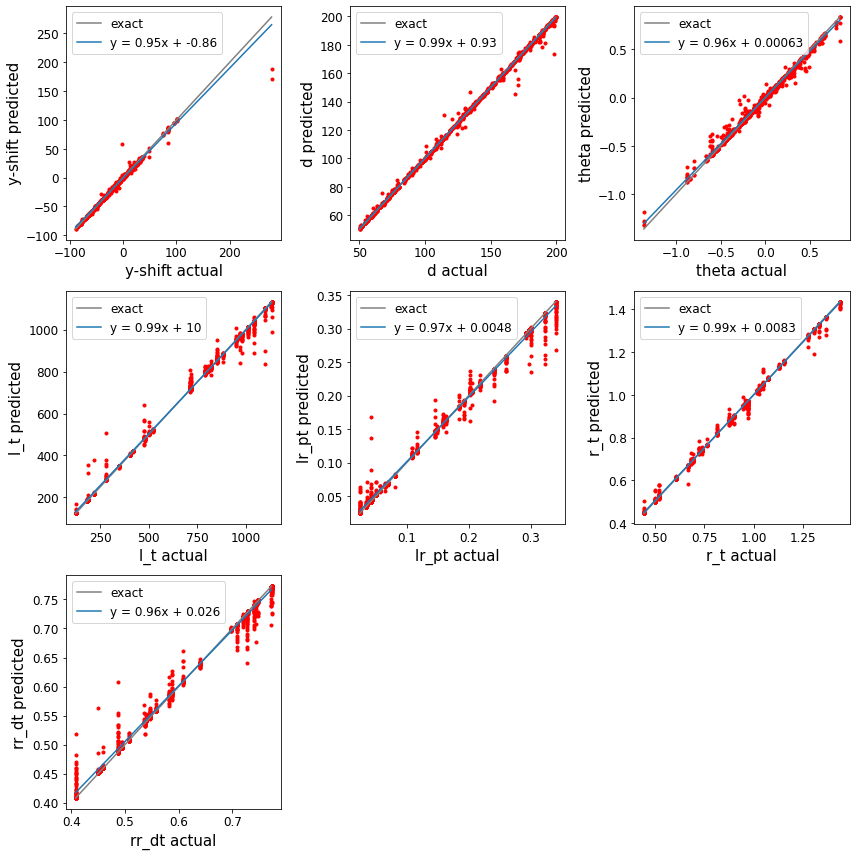

In [12]:
nlb = len(display_list)
nrows = int(np.ceil(nlb/3))

fontsize = 15
labelsize = 12
print("Stylized Cell Testing Data: Ground Truth VS Predicted")

fig = plt.figure(figsize=(12, 4 * nrows))
for i, lb in enumerate(display_list):
    ax = plt.subplot(nrows, 3, i+1)
    ax.scatter(y[:, i], output[:, i], c='red', marker='.')
    m, b = np.polyfit(y[:, i], output[:, i], 1)
    yl = np.array([np.amin(y[:, i]), np.amax(y[:, i])])
    ax.plot(yl, yl, color='gray', label='exact')
    ax.plot(yl, m * yl + b, label='y = %.2gx + %.2g' % (m,b))
    ax.set_xlabel(lb + ' actual', fontsize=fontsize)
    ax.set_ylabel(lb + ' predicted', fontsize=fontsize)
    ax.tick_params(labelsize=labelsize)
    ax.legend(loc=2, fontsize=labelsize)
plt.tight_layout()
plt.show()

### Feature importance

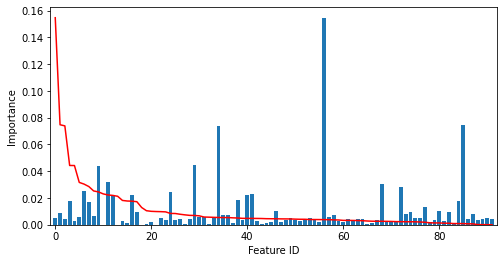

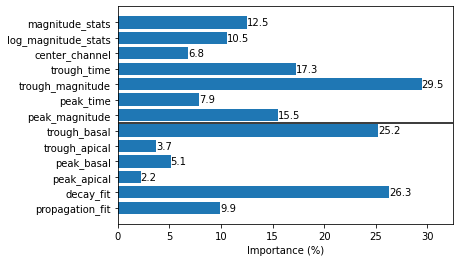

In [13]:
feat_df = pd.DataFrame({'id': range(model.n_features_in_), 'importance': model.feature_importances_,
                        'feature': summ_stats_names[:model.n_features_in_]})
feat_df.sort_values(by='importance', ascending=False, inplace=True, ignore_index=True)

plt.figure(figsize=(8, 4))
plt.bar(feat_df['id'], feat_df['importance'])
plt.plot(feat_df['importance'].values, 'r')
plt.xlim(-1, len(feat_df))
plt.xlabel('Feature ID')
plt.ylabel('Importance')

y_pos = np.arange(len(summ_stats_categories))
feat_cat_df = feat_df.set_index('id')
cat_importance = {c: 100 * feat_cat_df.loc[idx, 'importance'].sum() for c, idx in summ_stats_categories.items()}

fig, ax = plt.subplots(figsize=(6, 4))
hbars = ax.barh(y_pos, cat_importance.values(), align='center')
ax.bar_label(hbars, fmt='%.1f')
ax.set_yticks(y_pos)
ax.set_yticklabels(cat_importance.keys())
ax.axhline(n_parts - 0.5, color='k')
ax.invert_yaxis()
ax.set_xlabel('Importance (%)')
ax.set_xlim(left=0, right=1.05 * ax.get_xlim()[1])
plt.show()

In [14]:
cutoff_importance = 0.01
n_top = sum(feat_df['importance'] >= cutoff_importance)
top_feats = feat_df.iloc[:n_top]['id'].values

with pd.option_context('display.max_rows', None, 'display.float_format', '{:.3g}'.format):
    display(feat_df.iloc[:n_top])

,id,importance,feature
0,56,0.155,tr_l_w1
1,85,0.0747,log_avg_std
2,34,0.0739,pk_mean
3,29,0.0443,tr_mean
4,9,0.0443,t_tr_std
5,11,0.0317,t_tr_max_idx_y
6,68,0.0304,tr_l_avg_mag
7,72,0.0286,tr_l_t1
8,6,0.0253,avg_min_idx_y
9,24,0.0246,stdev_mean


## Train on important features

In [15]:
# model_red = RandomForestRegressor(random_state=randseed)
# model_red.fit(summ_stats_train[:, top_feats], labels_train)

### Evaluate model

In [16]:
# y = labels_test.copy()
# output = model_red.predict(summ_stats_test[:, top_feats])
# rmse = mean_squared_error(y, output, squared=False)
# print(f'RMSE: {rmse: .4g}')

# # back to original scale
# for i, lb in enumerate(label_list):
#     y[:, i] = org_scale(y[:, i], ranges[lb])
#     output[:, i] = org_scale(output[:, i], ranges[lb])

# # transform orientation variables
# if direction_vec:
#     output[:, orient_idx1] = trivarnorm2unitsphere(output[:, orient_idx1])
#     y = np.hstack([y, unitsphere2hphi(y[:, orient_idx1])[:, [1]]])
#     output = np.hstack([output, unitsphere2hphi(output[:, orient_idx1])[:, [1]]])

# # print("R2: {}".format(r2_score(y, output)))
# print('R2 Score:')
# for i, p in enumerate(display_list):
#     print('{:10} {:.3f}'.format(p+',', r2_score(y[:, i], output[:, i])))

In [17]:
# print("Stylized Cell Testing Data: Ground Truth VS Predicted")

# fig = plt.figure(figsize=(12, 4 * nrows))
# for i, lb in enumerate(display_list):
#     ax = plt.subplot(nrows, 3, i+1)
#     ax.scatter(y[:, i], output[:, i], c='red', marker='.')
#     m, b = np.polyfit(y[:, i], output[:, i], 1)
#     yl = np.array([np.amin(y[:, i]), np.amax(y[:, i])])
#     ax.plot(yl, yl, color='gray', label='exact')
#     ax.plot(yl, m * yl + b, label='y = %.2gx + %.2g' % (m,b))
#     ax.set_xlabel(lb + ' actual', fontsize=fontsize)
#     ax.set_ylabel(lb + ' predicted', fontsize=fontsize)
#     ax.tick_params(labelsize=labelsize)
#     ax.legend(loc=2, fontsize=labelsize)
# plt.tight_layout()
# plt.show()

### Feature importance

In [18]:
# feat_red_df = pd.DataFrame({'id': top_feats, 'importance': model_red.feature_importances_,
#                             'feature': summ_stats_names[top_feats]})
# feat_red_df.sort_values(by='importance', ascending=False, inplace=True, ignore_index=True)

# plt.figure(figsize=(8, 4))
# plt.bar(feat_red_df['id'], feat_red_df['importance'])
# plt.plot(feat_red_df['importance'].values, 'r')
# plt.xlim(-1, feat_red_df['id'].max()+ 1)
# plt.xlabel('Feature ID')
# plt.ylabel('Importance')
# plt.show()

# with pd.option_context('display.max_rows', None, 'display.float_format', '{:.3g}'.format):
#     display(feat_red_df)

## Train on selected outputs

In [19]:
select_label = ['l_t', 'lr_pt', 'r_t', 'rr_dt']
label_idx = [label_list.index(x) for x in select_label]

print(np.array(label_list)[label_idx])

['l_t' 'lr_pt' 'r_t' 'rr_dt']


In [20]:
model_sel = RandomForestRegressor(random_state=randseed)
model_sel.fit(summ_stats_train, labels_train[:, label_idx])

RandomForestRegressor(random_state=0)

### Evaluate model

In [21]:
y = labels_test.copy()[:, label_idx]
output = model_sel.predict(summ_stats_test)
rmse = mean_squared_error(y, output, squared=False)
print(f'RMSE: {rmse: .4g}')

print('R2 Score:')
for i, p in enumerate(label_idx):
    print('{:10} {:.3f}'.format(display_list[p]+',', r2_score(y[:, i], output[:, i])))

RMSE:  0.0576
R2 Score:
l_t,       0.995
lr_pt,     0.983
r_t,       0.997
rr_dt,     0.977


### Feature importance

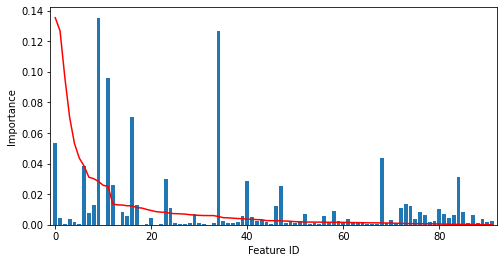

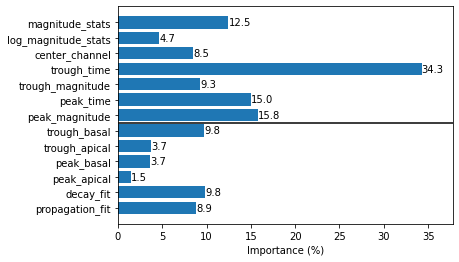

In [22]:
feat_labels_df = pd.DataFrame({'id': range(model_sel.n_features_in_), 'importance': model_sel.feature_importances_,
                        'feature': summ_stats_names[:model_sel.n_features_in_]})
feat_labels_df.sort_values(by='importance', ascending=False, inplace=True, ignore_index=True)

plt.figure(figsize=(8, 4))
plt.bar(feat_labels_df['id'], feat_labels_df['importance'])
plt.plot(feat_labels_df['importance'].values, 'r')
plt.xlim(-1, len(feat_labels_df))
plt.xlabel('Feature ID')
plt.ylabel('Importance')

y_pos = np.arange(len(summ_stats_categories))
feat_labels_cat_df = feat_labels_df.set_index('id')
cat_importance = {c: 100 * feat_labels_cat_df.loc[idx, 'importance'].sum() for c, idx in summ_stats_categories.items()}

fig, ax = plt.subplots(figsize=(6, 4))
hbars = ax.barh(y_pos, cat_importance.values(), align='center')
ax.bar_label(hbars, fmt='%.1f')
ax.set_yticks(y_pos)
ax.set_yticklabels(cat_importance.keys())
ax.axhline(n_parts - 0.5, color='k')
ax.invert_yaxis()
ax.set_xlabel('Importance (%)')
ax.set_xlim(left=0, right=1.05 * ax.get_xlim()[1])
plt.show()

In [23]:
cutoff_importance = 0.01
n_top = sum(feat_labels_df['importance'] >= cutoff_importance)

with pd.option_context('display.max_rows', None, 'display.float_format', '{:.3g}'.format):
    display(feat_labels_df.iloc[:n_top])

,id,importance,feature
0,9,0.135,t_tr_std
1,34,0.127,pk_mean
2,11,0.0962,t_tr_max_idx_y
3,16,0.0702,t_pk_mean
4,0,0.0532,avg_mean
5,68,0.0436,tr_l_avg_mag
6,6,0.0384,avg_min_idx_y
7,84,0.0311,log_avg_mean
8,23,0.0301,t_pk_min_val
9,40,0.0283,t1


## Train on individual output

In [24]:
model_label = []

for L_idx in label_idx:
    model_L = RandomForestRegressor(random_state=randseed)
    model_L.fit(summ_stats_train, labels_train[:, L_idx])
    model_label.append(model_L)

### Evaluate model

In [25]:
for model_L, L, L_idx in zip(model_label, select_label, label_idx):
    y = labels_test[:, L_idx]
    output = model_L.predict(summ_stats_test)
    rmse = mean_squared_error(y, output, squared=False)
    print(L)
    print(f'RMSE: {rmse: .4g}')
    print('R2 Score: {:.3f}'.format(r2_score(y, output)))

l_t
RMSE:  0.05692
R2 Score: 0.990
lr_pt
RMSE:  0.07046
R2 Score: 0.986
r_t
RMSE:  0.02395
R2 Score: 0.998
rr_dt
RMSE:  0.08742
R2 Score: 0.977


### Feature importance

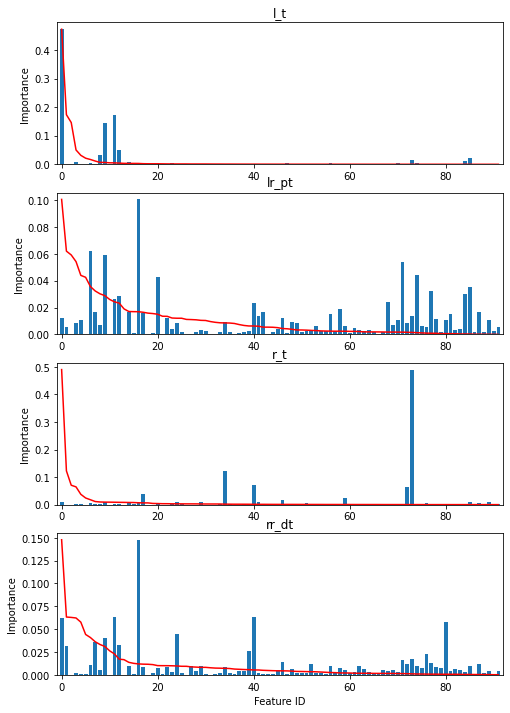

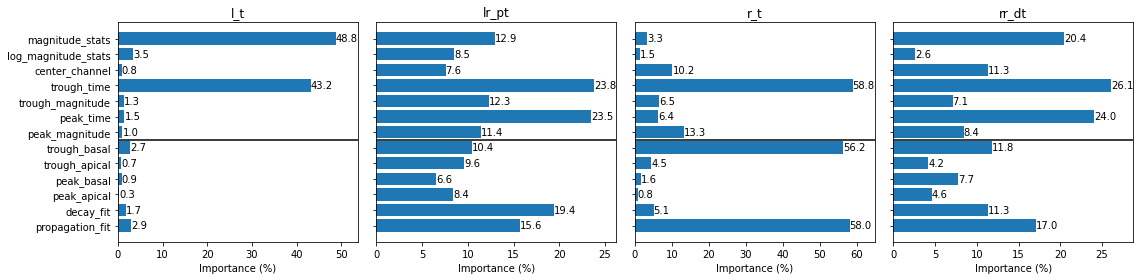

In [26]:
feat_label_df = {}
_, axs1 = plt.subplots(len(select_label), 1, figsize=(8, 3 * len(select_label)))
_, axs2 = plt.subplots(1, len(select_label), figsize=(4 * len(select_label), 4))
y_pos = np.arange(len(summ_stats_categories))

for i, (model_L, L) in enumerate(zip(model_label, select_label)):
    feat_L_df = pd.DataFrame({'id': range(model_L.n_features_in_), 'importance': model_L.feature_importances_,
                              'feature': summ_stats_names[:model_L.n_features_in_]})
    feat_L_df.sort_values(by='importance', ascending=False, inplace=True, ignore_index=True)
    feat_label_df[L] = feat_L_df

    ax = axs1[i]
    ax.bar(feat_L_df['id'], feat_L_df['importance'])
    ax.plot(feat_L_df['importance'].values, 'r')
    ax.set_title(L)
    ax.set_xlim(-1, feat_L_df['id'].max()+ 1)
    ax.set_ylabel('Importance')
    
    feat_L_cat_df = feat_L_df.set_index('id')
    cat_importance = {c: 100 * feat_L_cat_df.loc[idx, 'importance'].sum() for c, idx in summ_stats_categories.items()}
    ax = axs2[i]
    hbars = ax.barh(y_pos, cat_importance.values(), align='center')
    ax.bar_label(hbars, fmt='%.1f')
    if i:
        ax.set_yticks(y_pos)
        ax.set_yticklabels([])
    else:
        ax.set_yticks(y_pos)
        ax.set_yticklabels(cat_importance.keys())
    ax.axhline(n_parts - 0.5, color='k')
    ax.invert_yaxis()
    ax.set_xlim(left=0, right=1.05 * ax.get_xlim()[1])
    ax.set_xlabel('Importance (%)')
    ax.set_title(L)
axs1[-1].set_xlabel('Feature ID')
plt.tight_layout()
plt.show()

In [27]:
feat_alllabel_df = pd.concat(feat_label_df, axis=1)
with pd.option_context('display.max_rows', None, 'display.float_format', '{:.3g}'.format):
    display(feat_alllabel_df)

l_t                             lr_pt                             r_t  \
    id importance          feature    id importance          feature  id   
0    0      0.473         avg_mean    16      0.101        t_pk_mean  73   
1   11      0.174   t_tr_max_idx_y     6      0.062    avg_min_idx_y  34   
2    9      0.146         t_tr_std     9     0.0592         t_tr_std  40   
3   12     0.0502     t_tr_max_val    71     0.0542     pk_r_avg_mag  72   
4    8     0.0313        t_tr_mean    74      0.044          tr_r_t1  17   
5   85     0.0213      log_avg_std    20     0.0426     t_pk_max_val  59   
6   73     0.0168          tr_l_t2    85     0.0357      log_avg_std  46   
7   84     0.0114     log_avg_mean    77     0.0324          pk_l_t2  29   
8    3    0.00659    avg_max_idx_y    84     0.0303     log_avg_mean  24   
9   14    0.00645   t_tr_min_idx_y    12     0.0289     t_tr_max_val   0   
10  16    0.00518        t_pk_mean    11     0.0261   t_tr_max_idx_y  14   
11  56    0.00495          tr_l_w1    68     0.0243     tr_l_avg_mag   9   
12  70    0.00412     pk_l_avg_mag    40     0.0233               t1  41   
13  47    0.00321     t1_min_idx_y    58      0.019          tr_l_y1  85   
14   6    0.00308    avg_min_idx_y     7     0.0171      avg_min_val  89   
15  74    0.00304          tr_r_t1    87      0.017    log_stdev_std  76   
16  23    0.00293     t_pk_min_val    14     0.0169   t_tr_min_idx_y  16   
17  40    0.00211               t1    42     0.0165  t0_half_l_idx_y   6   
18   7    0.00182      avg_min_val    17     0.0159         t_pk_std  51   
19  87    0.00181    log_stdev_std    81     0.0156       tr_r_tprop  87   
20  72     0.0018          tr_l_t1    56     0.0151          tr_l_w1  74   
21  58    0.00157          tr_l_y1    73     0.0136          tr_l_t2  61   
22  83    0.00137       pk_r_tprop    41     0.0135               t2   3   
23  75    0.00124          tr_r_t2    46     0.0122     t1_max_idx_y  79   
24  27    0.00122  stdev_max_idx_y     0     0.0121         avg_mean  82   
25  89    0.00121       log_tr_std    22     0.0121   t_pk_min_idx_y  60   
26  77     0.0012          pk_l_t2    78     0.0112          pk_r_t1  12   
27  69    0.00107     tr_r_avg_mag     4     0.0111      avg_max_val  77   
28  91    0.00106       log_pk_std    89     0.0109       log_tr_std  81   
29  76    0.00106          pk_l_t1    70     0.0105     pk_l_avg_mag  47   
30  17    0.00102         t_pk_std    80     0.0104       tr_l_tprop  71   
31  68   0.000935     tr_l_avg_mag    34     0.0096          pk_mean  84   
32  80   0.000857       tr_l_tprop    48    0.00905      tr_lambda_l  58   
33  39   0.000842               t0    49    0.00868      tr_lambda_r  11   
34   1   0.000751          avg_std    72    0.00859          tr_l_t1  39   
35  34   0.000733          pk_mean     3    0.00851    avg_max_idx_y  68   
36  64   0.000669          pk_l_y1    24    0.00818       stdev_mean   8   
37  41   0.000613               t2     8    0.00736        t_tr_mean  15   
38  37   0.000582     pk_max_idx_y    69     0.0067     tr_r_avg_mag  56   
39  29   0.000544          tr_mean    53    0.00632      pk_lambda_r  25   
40  44    0.00052  t2_half_l_idx_y    75     0.0063          tr_r_t2  38   
41  63   0.000497          pk_l_w2    59    0.00613          tr_r_w1  35   
42  24   0.000488       stdev_mean     1    0.00545          avg_std   7   
43  78   0.000461          pk_r_t1    91    0.00545       log_pk_std   4   
44  82   0.000432       pk_l_tprop    76    0.00536          pk_l_t1  20   
45  61    0.00041          tr_r_y1    61    0.00507          tr_r_y1  52   
46  62   0.000409          pk_l_w1    45     0.0044  t2_half_r_idx_y  75   
47  81   0.000397       tr_r_tprop    23    0.00423     t_pk_min_val  78   
48  15   0.000345     t_tr_min_val    83    0.00383       pk_r_tprop  53   
49  79   0.000338          pk_r_t2    62    0.00335          pk_l_w1  48   
50   4   0.000337      avg_max_val    82    0.00333